# QuintoAndar - Data Analysis Case
#### Candidato: Renan Francis Moises

***

**A message to my future peers reviewing this case:**
    
_Hey, fellow colleagues, how are you? This has become a long analysis (as it deserved to be, I'd like to say) and for you guys that might not have much time to read there is a **TL;DR** sections at the end where I wrape it up briefly. So, feel free to [jump straight](#tldr) to that section if you'd like to. You can always come back to the analysis itself, which I tried to design in the format of a report._
    
_Hope hearing from you soon!_
    
_Best wishes,_
    
_Renan Moises._

## 0. Scope of this project
#### After observing that the number of rent contracts has been lowering over the year, QuintoAndar stakeholders wish to understand what may be causing the decline. This investigation aims to raise some hypotheses that could lead to actionable insights for reverting such a situation.

It is also important to point out that this analysis, due to the lack of certain information, is a proxy analysis. A proxy analysis is generally a first outlook to the problem, so managers and principals may decide to dig deeper. 

Along the way, we will:

- Analyze QuintoAndar database to which we have access;
- Understand what information is relevant for this analysis;
- Query the necessary information;
- Analyze the information itself, searching for the bottleneck that might be causing a decrease in contracts;
- With the bottlenecks identified, we will search for some possible causes;
- Make recommendations for reverting the contract decrease issue;
- Understand the limitations of this (proxy) analysis and identify what other information could help for a deeper investigation

## 1. QuintoAndar Database

The database contains seven tables. 
- three of them are summaries `visits_contracts`, `top10_neighbourhood` and `visits_offers_contracts`. In this investigation, I gathered data mostly from the last, `visits_offers_contracts`.


- four of them are versions tenant_reviews, being the `tenant_reviews_clean` the one used for this analysis.

Most of the tables do not have a primary or foreign key. `tenant_reviews_clean` do have a `house_id` column, and I used it as PK for required aggregations that will I present along the way.

### 1.1 Querying the database

!!! The queries were executed on PostgreSQL using DBeaver client. In this document, I will present the queries written in the SQL script as code text. !!!

#### (TABLE SQL #1)

The table visit_offers_contracts has summarized data from the other tables. We will use them to identify the bottlenecks of the contract funnel by creating some KPI's.
First, let's query its information.

````
SELECT *
FROM visit_offers_contracts voc;
````

***
#### (TABLE SQL #2)

I adopted the table `tenants_review_clean`  for summarizing `house_id` information such as dates of first and last visit, specific review topics, and general review as average. This information will be essential for later understanding what might be causing the observed problems. 

`````
/* Create index for improving performance over more than 1M entries */
CREATE INDEX idx_house_id ON tenant_reviews_clean(house_id);

SELECT house_id, 
	   neighbourhood,
       MIN(visit_date) first_visit, 
       MAX(visit_date) last_visit, 
       (MAX(visit_date) - MIN(visit_date)) days_btw_fv_lv,
       
/* The next block of code classifies varchars of length > 1 as NULL (some fields appeared as  'Visita não realizada', making it impossible to compute the average of the column), and varchars with a length = 1 character (numbers from 1 to 5) as data type float, for proper average calculus) */

       AVG(CASE WHEN LENGHT(review) > 1 then
       				NULL
       			ELSE
       				CAST(review AS float)
   				END) avg_review,
   	(SELECT COUNT(review)) n_reviews,
    
/* The next block of code transform checkbox data to boolean (0 for false, 1 for positive) */
   
   	COUNT(CASE WHEN building THEN 1 END) building,
   	COUNT(CASE WHEN conservation THEN 1 END) conservation,
   	COUNT(CASE WHEN size THEN 1 END) size,
   	COUNT(CASE WHEN price THEN 1 END) price,
   	COUNT(CASE WHEN trc."location" THEN 1 END) "location",
   	COUNT(CASE WHEN did_not_like_the_location THEN 1 END) dislike_location,
   	COUNT(CASE WHEN expected_a_better_preserved_property THEN 1 END) unpreserved_property,
   	COUNT(CASE WHEN bigger_in_photos THEN 1 END) bigger_in_photos,
   	COUNT(CASE WHEN different_from_the_listing THEN 1 END different_from_the_listing
    
FROM tenant_reviews_clean trc

/* Group by house_id so we can analyze based on each apartment instead of each visit */

GROUP BY house_id, neighbourhood
ORDER BY house_id, n_reviews;
`````

After querying the database, I exported the information to a `.csv` file and then transferred the analysis to Python. Python, as an object-oriented programming language, allows a boost in performance for manipulating data. Since most aggregating functions were already built in PostreSQL, the data loaded into a Jupyter Notebook will be easily maneuverable.

## 2. Data Analysis - KPIs

### 2.1 Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import calendar as cal

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)

### 2.2 Importing CSV file to Jupyter Notebook

In [2]:
# Importing 'visits_offer_contracts' summary table to Notebook
summary = pd.read_csv('visits_offers_contracts_202009221736.csv')
summary

,month,visits,tenant_that_visited,visited_houses,offers,tenants_that_made_offers,contracts
0,jan,7130,4678,4140,3924,2977,724
1,fev,7132,5193,4322,3658,2461,689
2,mar,6933,5322,4299,3791,2526,667
3,abr,7342,5844,3150,2453,1699,603
4,mai,7238,6112,4006,3587,2645,544
5,jun,8377,6710,3250,3011,1583,542
6,jul,8130,7122,3993,3500,1801,443
7,ago,8288,7630,4155,3431,1857,376


### 2.3 Studying possible KPIs

The best way to understand performance is through a KPI analysis. Combining some of the information from the previous table (here onwards called dataset), we might be able to observe some trends.

One of the most important things about KPIs is that they **must** be comprehensible. Because of that, let's change some column names. It will make the information more readable and fast processing (for our brains!)

In [3]:
# Renaming dataset columns for better understanding of KPIs
summary.columns = ['month', 
                   'scheduled_visits', # Based on the other columns, I assumed 'visit' referred to the scheduled visit
                   'n_tenants_visiting', 
                   'n_houses_visited', 
                   'n_offers', 
                   'n_tenants_offering', 
                   'contracts']

summary

,month,scheduled_visits,n_tenants_visiting,n_houses_visited,n_offers,n_tenants_offering,contracts
0,jan,7130,4678,4140,3924,2977,724
1,fev,7132,5193,4322,3658,2461,689
2,mar,6933,5322,4299,3791,2526,667
3,abr,7342,5844,3150,2453,1699,603
4,mai,7238,6112,4006,3587,2645,544
5,jun,8377,6710,3250,3011,1583,542
6,jul,8130,7122,3993,3500,1801,443
7,ago,8288,7630,4155,3431,1857,376


### 2.3.1 KPIs candidates

#### Let's consider some KPIs candidates:

- How many visits do a house gets on average per month?
- How many offers do a house receives on average per month?
- How many offers did each tenant made on average per month?
- How many contracts were signed for each offer made on average per month? 
- How many visits did actually happen on average per month?

Now let's code it:

In [4]:
# How many houses each tenant visited per month
summary['tenant_visits_per_house'] = summary['n_tenants_visiting'] / summary['n_houses_visited']

# How many offers per house visited
summary['offers_per_house_visited'] = summary['n_houses_visited'] / summary['n_offers']

# How many offers each tenant offered
summary['offers_per_tenant'] = summary['n_offers'] / summary['n_tenants_offering'] # The number of offers 
                                                                                   # per tenant has seem a strike rise

# How many contracts per tenant offer
summary['contracts_per_offer'] = summary['contracts'] / summary['n_offers'] 

# How many scheduled visits did actually happen
summary['pct_effective_visits'] = summary['n_tenants_visiting'] / summary['scheduled_visits']

summary

,month,scheduled_visits,n_tenants_visiting,n_houses_visited,n_offers,n_tenants_offering,contracts,tenant_visits_per_house,offers_per_house_visited,offers_per_tenant,contracts_per_offer,pct_effective_visits
0,jan,7130,4678,4140,3924,2977,724,1.129952,1.055046,1.318105,0.184506,0.656101
1,fev,7132,5193,4322,3658,2461,689,1.201527,1.181520,1.486388,0.188354,0.728127
2,mar,6933,5322,4299,3791,2526,667,1.237962,1.134002,1.500792,0.175943,0.767633
3,abr,7342,5844,3150,2453,1699,603,1.855238,1.284142,1.443790,0.245821,0.795968
4,mai,7238,6112,4006,3587,2645,544,1.525711,1.116811,1.356144,0.151659,0.844432
5,jun,8377,6710,3250,3011,1583,542,2.064615,1.079376,1.902085,0.180007,0.801003
6,jul,8130,7122,3993,3500,1801,443,1.783621,1.140857,1.943365,0.126571,0.876015
7,ago,8288,7630,4155,3431,1857,376,1.836342,1.211017,1.847604,0.109589,0.920608


The numbers are promising. Some show considerable growth, while others are not doing so well.

### 2.3.2 Growth Analysis
#### Let's investigate further with a Growth Analysis.

In [5]:
kpis = ['pct_effective_visits',
        'tenant_visits_per_house', 
        'offers_per_house_visited', 
        'offers_per_tenant', 
        'n_tenants_offering',        
        'contracts_per_offer']

for kpi in kpis:
    growth = round((((summary[kpi].iloc[-1] - summary[kpi].iloc[0]) / summary[kpi].iloc[-1]) * 100), 2)
    growth_monthly = round((((summary[kpi].iloc[-1] / summary[kpi].iloc[0])**(1/len(summary))) - 1) * 100, 2)
        
    print('KPI: {}; Period Growth: {}%, Monthly Growth {}% \n'.format(kpi, growth, growth_monthly), end = '\n')

KPI: pct_effective_visits; Period Growth: 28.73%, Monthly Growth 4.32% 

KPI: tenant_visits_per_house; Period Growth: 38.47%, Monthly Growth 6.26% 

KPI: offers_per_house_visited; Period Growth: 12.88%, Monthly Growth 1.74% 

KPI: offers_per_tenant; Period Growth: 28.66%, Monthly Growth 4.31% 

KPI: n_tenants_offering; Period Growth: -60.31%, Monthly Growth -5.73% 

KPI: contracts_per_offer; Period Growth: -68.36%, Monthly Growth -6.3% 



## 2.4 KPIs and growth analysis conclusions:

1. People are indeed visiting houses for visits they schedule. The **whole period growth** is **28.17%** and **monthly growth** of **4.32%**;
2. An average house receives visits by considerably more tenants, having a **whole period growth** of **38.47%** (**monthly** of **6.26%**);
3. One average house (visited) is receiving more offers, with **whole period growth** of **12.88%** (**monthly** of **1.74%**);
4. Tenants are, on average, making more offers than before. **Whole period growth** of **28.66%** (**monthly** of **4.31%**);


5. Considerably fewer tenants are making offers, with a **60.31%** **_decrease_** in the **whole period** and **monthly _decrease_** of **5.73%**;
6. Much fewer contracts are being signed, having this KPI **_decreased_** **68.36%** in the **whole period** and **6.3%** monthly.

#### Now that we have read the numbers. Let's visualize them in graphs.

## 3. Data visualization

In [6]:
# Setting things up

#Tranforming 'month' into a datatime objetct.
summary['month_x'] = [1, 2, 3, 4, 5, 6, 7, 8]
summary['month'] = summary['month_x'].apply(lambda x: cal.month_abbr[x])

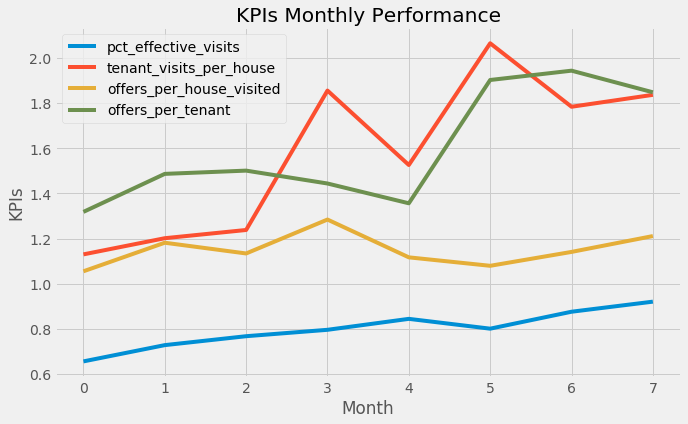

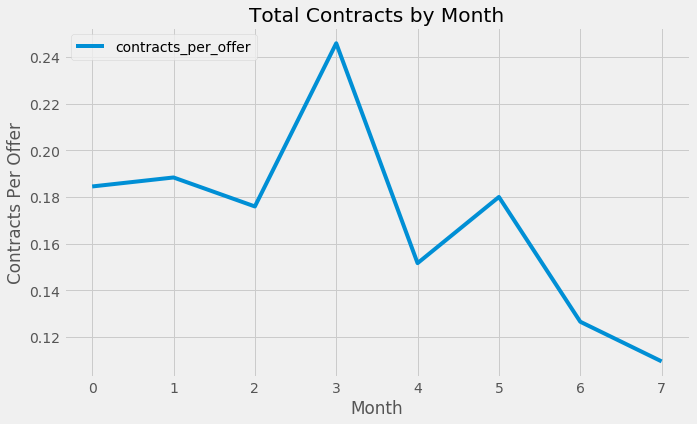

In [36]:
# Data could be standardized, but the magnitudes of four of our KPIs are not that different, 
# therefore, I opted not to do it.

kpis_good = ['pct_effective_visits',
        'tenant_visits_per_house', 
        'offers_per_house_visited', 
        'offers_per_tenant']

kpis_bad = ['contracts_per_offer']

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize = (10, 6))
for kpi in kpis_good:
    plt.plot(summary[kpi], label = kpi)
    
plt.legend(loc = 'best')
plt.xlabel('Month')
plt.ylabel('KPIs')
plt.title('KPIs Monthly Performance')
plt.show()

fig = plt.figure(figsize = (10, 6))
for kpi in kpis_bad:
    plt.plot(summary[kpi], label = kpi)
    
plt.xlabel('Month')
plt.ylabel('Contracts Per Offer')
plt.title('Total Contracts by Month')
plt.legend(loc = 'upper left')
plt.show()

##### This analysis shows that the number of tenants making _offers_ has decreased significantly, taking with it the number of contracts signed. 

##### We should investigate what is causing tenants to cease offers.

****

## 4. Data Analysis - Hypothesis screening

In this part of the analysis, I am going to take a closer look at the `house_reviews` dataset (taken from PostgreSQL, as shown in QUERY SQL #2).

The dataset contains information for every visit scheduled, reviews (including specific fields), and dates for visits scheduled. 

It also includes the dates of the first visit scheduled in the year and the last one. This information is interesting because calculating the difference between first and last visits we can have a proxy of how long the house was available. It is a proxy because with the information we have in the database it is not possible to check if the house was rented and later unoccupied, but, considering most contracts stands for at least more than one year, it seems unlikely this situation in representative in the dataset.

Houses that take longer than the average to be rented **certainly** has a reason for that. I will take a look at that information as well.

#### Let's take a look at the house_reviews dataset then!

In [8]:
house_reviews = pd.read_csv('query3.csv')
house_reviews

,house_id,neighbourhood,min,max,days_until_rent,avg_review,n_reviews,building,conservation,size,price,location,dislike_location,unpreserved_property,bigger_in_photos,different_from_the_listing
0,892763958,Centro,2018-06-22,2018-06-22,0,NaN,0,0,0,0,0,0,0,0,0,0
1,892764283,Chacara Primavera,2018-03-15,2018-03-15,0,5.0,1,0,1,1,1,0,0,0,0,0
2,892764364,Consolação,2018-07-25,2018-07-25,0,3.0,1,0,0,0,0,0,1,0,0,0
3,892764557,Perdizes,2018-02-26,2018-02-26,0,NaN,0,0,0,0,0,0,0,0,0,0
4,892764702,Cidade Monções,2018-05-10,2018-06-13,34,3.0,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6179,892844262,Copacabana,2018-08-31,2018-08-31,0,5.0,1,1,1,1,1,1,0,0,0,0
6180,892844284,Liberdade,2018-08-29,2018-08-29,0,5.0,1,0,1,0,1,1,0,0,0,0
6181,892844285,República,2018-08-30,2018-08-30,0,5.0,1,1,1,1,0,0,0,0,0,0
6182,892844474,Jardim Proença,2018-08-30,2018-08-30,0,NaN,0,0,0,0,0,0,0,0,0,0


In [9]:
# Total neighbourhoods
house_reviews['neighbourhood'].nunique()

305

### 4.1 Analyzing duplicates

#### Since we queried grouping by `house_id`, all entries for that field should be unique. For the sake of my sanity, let's confirm if this is true.

In [10]:
duplicated_sum = sum(house_reviews['house_id'].duplicated() == True)

if duplicated_sum == 0:
    print("There is no duplicated 'house_id' values. Dataset is good to go!")
else:
    print("There are {} duplicated values in the dataset. Something is wrong!".format(duplicated_sum))

There is no duplicated 'house_id' values. Dataset is good to go!


### 4.2 Aggregating the issues (items reviewed and checked as 1, that is, true) as a sum.
The dataset contains boolean information for every item reviewed by a tenant, but not an aggregated one. For each `house_id` I am going to sum all the issues in a single column. It will help me to understand the state of the house, according to most prospective tenants.

In [11]:
# Creating a column with the sum of total_issues
house_reviews['total_issues'] = house_reviews.loc[:, 'building':'different_from_the_listing'].sum(axis = 1)

house_reviews

,house_id,neighbourhood,min,max,days_until_rent,avg_review,n_reviews,building,conservation,size,price,location,dislike_location,unpreserved_property,bigger_in_photos,different_from_the_listing,total_issues
0,892763958,Centro,2018-06-22,2018-06-22,0,NaN,0,0,0,0,0,0,0,0,0,0,0
1,892764283,Chacara Primavera,2018-03-15,2018-03-15,0,5.0,1,0,1,1,1,0,0,0,0,0,3
2,892764364,Consolação,2018-07-25,2018-07-25,0,3.0,1,0,0,0,0,0,1,0,0,0,1
3,892764557,Perdizes,2018-02-26,2018-02-26,0,NaN,0,0,0,0,0,0,0,0,0,0,0
4,892764702,Cidade Monções,2018-05-10,2018-06-13,34,3.0,1,0,0,0,0,0,0,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6179,892844262,Copacabana,2018-08-31,2018-08-31,0,5.0,1,1,1,1,1,1,0,0,0,0,5
6180,892844284,Liberdade,2018-08-29,2018-08-29,0,5.0,1,0,1,0,1,1,0,0,0,0,3
6181,892844285,República,2018-08-30,2018-08-30,0,5.0,1,1,1,1,0,0,0,0,0,0,3
6182,892844474,Jardim Proença,2018-08-30,2018-08-30,0,NaN,0,0,0,0,0,0,0,0,0,0,0


### 4.3 Parsing dates for later grouping by month

Sooner in this document, I identified that the drop in contracts happened mainly in the last quarter. So grouping issues by month could potentially show if tenants reported more issues at the same time the number of contracts drop. If so, this could be a good indicator of dissatisfaction with what has been offered, and could lead to a management intervention aiming to bring it back on tracks.

To do so, it is necessary to convert some data types. Both `min` and `max` data types are 'strings' which is inadequate for parsing dates and then grouping by month. Let's do it!

In [12]:
#Converting 'fv' and 'lv' columns to date data type.
house_reviews['first_visit'] = pd.to_datetime(house_reviews['min'])
house_reviews['last_visit'] = pd.to_datetime(house_reviews['max'])

# Parsing day, month and year from new date data type for first_visit dates.
house_reviews['fv_day'] = house_reviews['first_visit'].dt.day
house_reviews['fv_month'] = house_reviews['first_visit'].dt.month
house_reviews['fv_year'] = house_reviews['first_visit'].dt.year

# Parsing day, month and year from new date data type for last_visit dates.
house_reviews['lv_day'] = house_reviews['last_visit'].dt.day
house_reviews['lv_month'] = house_reviews['last_visit'].dt.month
house_reviews['lv_year'] = house_reviews['last_visit'].dt.year   

house_reviews

,house_id,neighbourhood,min,max,days_until_rent,avg_review,n_reviews,building,conservation,size,...,different_from_the_listing,total_issues,first_visit,last_visit,fv_day,fv_month,fv_year,lv_day,lv_month,lv_year
0,892763958,Centro,2018-06-22,2018-06-22,0,NaN,0,0,0,0,...,0,0,2018-06-22,2018-06-22,22,6,2018,22,6,2018
1,892764283,Chacara Primavera,2018-03-15,2018-03-15,0,5.0,1,0,1,1,...,0,3,2018-03-15,2018-03-15,15,3,2018,15,3,2018
2,892764364,Consolação,2018-07-25,2018-07-25,0,3.0,1,0,0,0,...,0,1,2018-07-25,2018-07-25,25,7,2018,25,7,2018
3,892764557,Perdizes,2018-02-26,2018-02-26,0,NaN,0,0,0,0,...,0,0,2018-02-26,2018-02-26,26,2,2018,26,2,2018
4,892764702,Cidade Monções,2018-05-10,2018-06-13,34,3.0,1,0,0,0,...,0,2,2018-05-10,2018-06-13,10,5,2018,13,6,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6179,892844262,Copacabana,2018-08-31,2018-08-31,0,5.0,1,1,1,1,...,0,5,2018-08-31,2018-08-31,31,8,2018,31,8,2018
6180,892844284,Liberdade,2018-08-29,2018-08-29,0,5.0,1,0,1,0,...,0,3,2018-08-29,2018-08-29,29,8,2018,29,8,2018
6181,892844285,República,2018-08-30,2018-08-30,0,5.0,1,1,1,1,...,0,3,2018-08-30,2018-08-30,30,8,2018,30,8,2018
6182,892844474,Jardim Proença,2018-08-30,2018-08-30,0,NaN,0,0,0,0,...,0,0,2018-08-30,2018-08-30,30,8,2018,30,8,2018


In [13]:
# Setup: renaming columns for better understanding
house_reviews.columns = ['house_id', 'neighbourhood', 'fv', 'lv', 'days_btw_fv_lv',
                         'avg_review', 'n_reviews', 'building', 'conservation', 'size', 'price',
                         'location', 'dislike_location', 'unpreserved_property',
                         'bigger_in_photos', 'different_from_the_listing', 'total_issues',
                         'first_visit', 'last_visit', 'fv_day', 'fv_month', 'fv_year', 'lv_day',
                         'lv_month', 'lv_year']

### 4.4 Droping unuseful data
#### There are though some entries from 2017. Since this analysis scope revolves around the year 2018, let's drop these values.


In [14]:
drop_2017_labels = house_reviews[house_reviews.loc[:, 'fv_year'] == 2017]
drop_2017_labels['fv_year'].count() # There are 4 entries from 2017. We should remove them.

# Let's drop entries from year 2017, since it is not part of our analysis
house_reviews = house_reviews[house_reviews['fv_year'] == 2018]
house_reviews

,house_id,neighbourhood,fv,lv,days_btw_fv_lv,avg_review,n_reviews,building,conservation,size,...,different_from_the_listing,total_issues,first_visit,last_visit,fv_day,fv_month,fv_year,lv_day,lv_month,lv_year
0,892763958,Centro,2018-06-22,2018-06-22,0,NaN,0,0,0,0,...,0,0,2018-06-22,2018-06-22,22,6,2018,22,6,2018
1,892764283,Chacara Primavera,2018-03-15,2018-03-15,0,5.0,1,0,1,1,...,0,3,2018-03-15,2018-03-15,15,3,2018,15,3,2018
2,892764364,Consolação,2018-07-25,2018-07-25,0,3.0,1,0,0,0,...,0,1,2018-07-25,2018-07-25,25,7,2018,25,7,2018
3,892764557,Perdizes,2018-02-26,2018-02-26,0,NaN,0,0,0,0,...,0,0,2018-02-26,2018-02-26,26,2,2018,26,2,2018
4,892764702,Cidade Monções,2018-05-10,2018-06-13,34,3.0,1,0,0,0,...,0,2,2018-05-10,2018-06-13,10,5,2018,13,6,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6179,892844262,Copacabana,2018-08-31,2018-08-31,0,5.0,1,1,1,1,...,0,5,2018-08-31,2018-08-31,31,8,2018,31,8,2018
6180,892844284,Liberdade,2018-08-29,2018-08-29,0,5.0,1,0,1,0,...,0,3,2018-08-29,2018-08-29,29,8,2018,29,8,2018
6181,892844285,República,2018-08-30,2018-08-30,0,5.0,1,1,1,1,...,0,3,2018-08-30,2018-08-30,30,8,2018,30,8,2018
6182,892844474,Jardim Proença,2018-08-30,2018-08-30,0,NaN,0,0,0,0,...,0,0,2018-08-30,2018-08-30,30,8,2018,30,8,2018


In [15]:
# Total houses with 3 or more issues reported in the whole period
houses_3_more_issues = house_reviews['total_issues'].value_counts()[3:35].sum()
houses_3_more_issues

# Total houses with 3 or more issues reported in the last 3 months (6, 7, 8)
houses_3_more_issues_3_m678 = house_reviews[house_reviews['lv_month'] >= 6]['total_issues'].value_counts()[3:35].sum()
houses_3_more_issues_3_m678

pct_issues_m678 = houses_3_more_issues_3_m678 / houses_3_more_issues
pct_issues_m678

print('{}% of houses with 3 or more issues were reported in the last 3 months.'.format(round((pct_issues_m678 * 100), 2)))

54.96% of houses with 3 or more issues were reported in the last 3 months.


#### 4.4.1 Let's visualize the growth of issues monthly in a graph

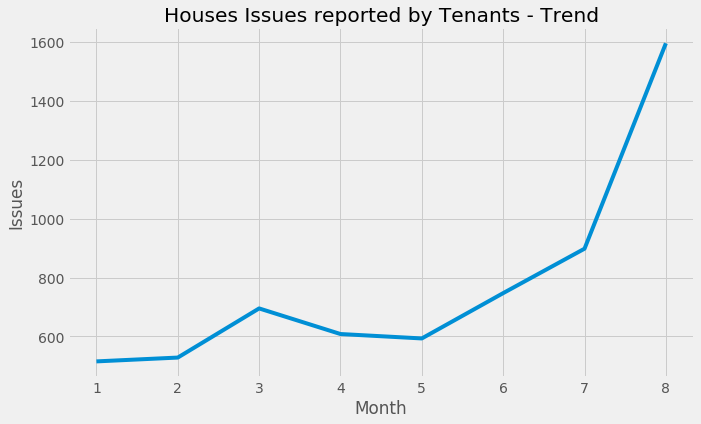

In [37]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize = (10, 6))
plt.plot(house_reviews.groupby('lv_month')['total_issues'].count())
plt.xlabel('Month')
plt.ylabel('Issues')
plt.title('Houses Issues reported by Tenants - Trend')
plt.show();

### 4.5 Issue breakdown investigation

The percentage of issues increased enormously in the last three months, compared to the whole period.

Let's investigate if some specific issues or all of them are contributing to the rise.

In [17]:
# Let's break down the issues and see what bothers tenants more by month
issues_list = ['building', 'conservation', 'size', 'price',
               'location', 'dislike_location', 'unpreserved_property',
               'bigger_in_photos', 'different_from_the_listing']

issues_groupedby_month = house_reviews.groupby('lv_month')[issues_list].sum()
issues_groupedby_month

,building,conservation,size,price,location,dislike_location,unpreserved_property,bigger_in_photos,different_from_the_listing
lv_month,,,,,,,,,
1,173,199,201,155,274,28,129,92,28
2,209,260,255,163,320,58,154,100,28
3,295,374,381,262,478,75,185,149,32
4,257,326,332,221,422,70,165,144,28
5,251,318,324,211,391,49,192,138,24
6,315,416,389,275,501,98,214,150,30
7,404,527,531,353,646,90,304,202,39
8,772,987,965,702,1232,213,634,411,88


#### 4.5.1 Let's break it even further considering the whole period and monthly growth

In [18]:
for issue in issues_list:
    issue_growth = round((((issues_groupedby_month[issue].iloc[-1] - issues_groupedby_month[issue].iloc[0]) / 
                     issues_groupedby_month[issue].iloc[-1]) * 100), 2)
    
    issue_growth_monthly = round((((issues_groupedby_month[issue].iloc[-1] / issues_groupedby_month[issue].iloc[0])**(1/len(issues_groupedby_month))) - 1) * 100, 2)
        
    print('Issue type: {}; Period Growth: {}%, Monthly Growth {}% \n'.format(issue, 
                                                                      issue_growth, 
                                                                      issue_growth_monthly), end = '\n')

Issue type: building; Period Growth: 77.59%, Monthly Growth 20.56% 

Issue type: conservation; Period Growth: 79.84%, Monthly Growth 22.16% 

Issue type: size; Period Growth: 79.17%, Monthly Growth 21.67% 

Issue type: price; Period Growth: 77.92%, Monthly Growth 20.78% 

Issue type: location; Period Growth: 77.76%, Monthly Growth 20.67% 

Issue type: dislike_location; Period Growth: 86.85%, Monthly Growth 28.87% 

Issue type: unpreserved_property; Period Growth: 79.65%, Monthly Growth 22.02% 

Issue type: bigger_in_photos; Period Growth: 77.62%, Monthly Growth 20.57% 

Issue type: different_from_the_listing; Period Growth: 68.18%, Monthly Growth 15.39% 



#### 4.5.2 Let's visualize it with a graph as well

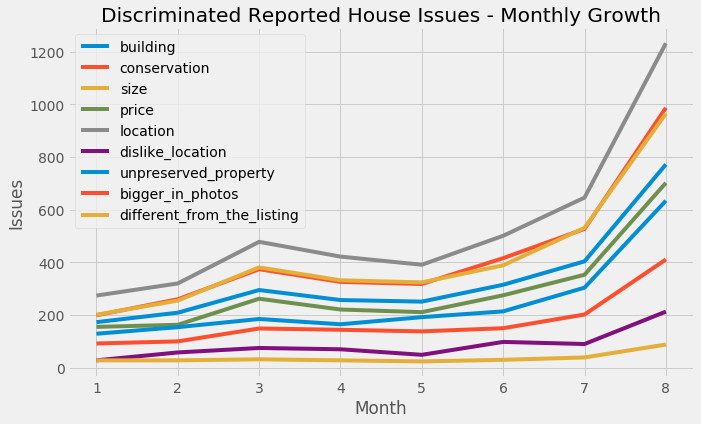

In [40]:
issues_list = ['building', 'conservation', 'size', 'price',
               'location', 'dislike_location', 'unpreserved_property',
               'bigger_in_photos', 'different_from_the_listing']

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize = (10, 6))

for issue in issues_list:
    plt.plot(issues_groupedby_month[issue], label = issue)

plt.xlabel('Month')
plt.ylabel('Issues')
plt.title('Discriminated Reported House Issues - Monthly Growth')
plt.legend(loc = 'best')
plt.show()

##### The number of issues reported in the last three months grew extensively and consistently, indicating that the previously mentioned dissatisfaction from tenants with properties available for rent is real. This is a good proxy of why contracts have been decreasing.

##### Before packing up the analysis and heading towards the consideration of this investigation, let's take a look at houses that were available to rent on the last 15 days prior to the end of the quarter.

### 4.6 Houses available to rent at the end of the quarter

In [20]:
house_reviews[house_reviews['last_visit'] == house_reviews['last_visit'].max()]

,house_id,neighbourhood,fv,lv,days_btw_fv_lv,avg_review,n_reviews,building,conservation,size,...,different_from_the_listing,total_issues,first_visit,last_visit,fv_day,fv_month,fv_year,lv_day,lv_month,lv_year
66,892776485,Indianópolis,2018-07-11,2018-08-31,51,4.250000,8,2,3,2,...,0,14,2018-07-11,2018-08-31,11,7,2018,31,8,2018
292,892787838,Santo Amaro,2018-08-30,2018-08-31,1,4.500000,2,1,1,1,...,0,6,2018-08-30,2018-08-31,30,8,2018,31,8,2018
425,892791260,Campo Belo,2018-05-07,2018-08-31,116,4.000000,1,0,0,0,...,0,0,2018-05-07,2018-08-31,7,5,2018,31,8,2018
458,892792098,Jardim Paulista,2018-08-27,2018-08-31,4,5.000000,2,0,1,1,...,0,6,2018-08-27,2018-08-31,27,8,2018,31,8,2018
501,892792972,Santa Paula,2018-05-09,2018-08-31,114,3.666667,3,0,0,0,...,0,3,2018-05-09,2018-08-31,9,5,2018,31,8,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,892844096,Vila Mariana,2018-08-31,2018-08-31,0,5.000000,1,0,1,1,...,0,4,2018-08-31,2018-08-31,31,8,2018,31,8,2018
6177,892844212,Centro,2018-08-30,2018-08-31,1,2.000000,2,0,0,0,...,1,3,2018-08-30,2018-08-31,30,8,2018,31,8,2018
6178,892844227,Vila Isabel,2018-08-31,2018-08-31,0,5.000000,1,1,1,1,...,0,5,2018-08-31,2018-08-31,31,8,2018,31,8,2018
6179,892844262,Copacabana,2018-08-31,2018-08-31,0,5.000000,1,1,1,1,...,0,5,2018-08-31,2018-08-31,31,8,2018,31,8,2018


In [21]:
# Investigating houses with 15 of more days on QuintoAndar's listing, with last visit scheduled 
# between 16/08/2018 and 31/08/2018 and at least one issue reported. 

houses_15dayslisted_last2w = house_reviews[house_reviews['days_btw_fv_lv'] >= 15][house_reviews['last_visit'] > 
                                                     "2018-08-15"]

h15days_last2w_count = houses_15dayslisted_last2w.shape[0] #382 houses listed in the last 2 weeks, with at least 15 days in the listing

h15days_last2w_totissues_count = houses_15dayslisted_last2w[house_reviews['total_issues'] >= 
                                                            5]['total_issues'].shape[0] # 274 of 382 houses 
                                                                                        # have at least 3 issues
round(h15days_last2w_totissues_count / h15days_last2w_count * 100, 2)

59.95

##### 60% of houses with more than 15 days in the QuintoAndar's listing, and listed still listed in the last two weeks prior to the end of August, has at least 5 issues reported. This number corroborates the idea that most houses available to rent has been disliked by prospective tenants.

***

<a id='tldr'></a>
# Wrapping it up (TL;DR)

### 1. What seems to be happening?

The specific designed KPIs showed that the business activity - the percentage of effective visits, houses have more visitors, houses visited receives more offers than previous months, one average tenant is making more than one offer - is growing. Two indicators though showed that the effective number of contracts signed is lowering. That is happening because tenants, in general, are making fewer offers.

#### Hypothesis
**In a further investigation, we saw that the average number of issues reported by tenants rose considerably. That may be the main reason why contracts are not being signed.**

As we saw, most tenants are considering more houses to rent than before and on a more holistic view, QuintoAndar should also study the impact effect of The Paradox of Choice. Such paradox has been studied in consumer psychology over the last two decades, and according to Berry Schwartz - author of the book **_The Paradox of Choice – Why More Is Less_**, published in 2004, the more choices a consumer has, the more frustrated it gets when choosing one of many possibilities to be chosen:

_"Schwartz finds that when people are faced with having to choose one option out of many desirable choices, they will begin to consider hypothetical trade-offs. Their options are evaluated in terms of missed opportunities instead of the opportunity's potential. In other words, after choosing an alternative with a plurality but not a majority of utility, people remember the sum of the lost utility rather than that they made the utility-maximizing choice. Schwartz maintains that one of the downsides of making trade-offs is it alters how we feel about the decisions we face; afterward, it affects the level of satisfaction we experience from our decision. While psychologists have known for years about the harmful effects of negative emotion on decision making, Schwartz points to recent evidence showing how positive emotion has the opposite effect: in general, subjects are inclined to consider more possibilities when they are feeling happy."_

### 2 and 3. Other relevant information to be included in this study and other recommended analysis.

The database as presented contains relevant information, but since they are not _exactly_ a relational database, it gets difficult for better assertive analysis. There are more data we should consider having at hands for this study, below I list some of them:

I would consider querying other tables - not available at the moment - such as **TENANT TABLE**, with tenant_id and its relation with specifics house_id's, which house each tenant visited, what are his preferences towards a house to rent.

A **HOUSE TABLE** would also be relevant. First, it could be used to match house specifications to tenants' preferences allowing a more accurate and concise recommendation, that could also be implemented when working with the Data Science Team and the UX Team. The HOUSE TABLE, with a city column, would also be useful to study markets separately. In the same database, we have data from Rio de Janeiro and São Paulo, with more than 300 neighborhoods from both cities. Analyzing it separately, we could investigate if the trends are the same in both cities, and if not it would be possible to understand both consumers for its particularities.

An **OFFER TABLE** would help ups analyze tenants and house owners' behaviors towards rent price negotiation, as well as understanding houses that might be mispriced. The analysis from this table are countless, but one of the most interesting would be used to help house owners identify if they have inadequate pricing, and potentially helping them reach a price that would help them rent faster, reducing the loss with unrented houses for long periods of time.

Back to the **VISITS TABLE**, implementing Foreign Keys from the tables mentioned above would allow us to understand how visits go relating it to the tenant profile and house specificities. Then uniting UX Team, Business Analysts, and Data Team, we could design a proper A/B testing of an implemented feature aiming to reduce the exposure of tenants to hundreds of houses and study if from this test the number of contracts rises. 